# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `1_create_the_gene_table.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_contents
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
# Enter the location of your data here
data_dir = path.join('..','data','processed_data')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join('..','data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata.tsv'),index_col=0,sep='\t')
df_metadata[['project','condition']].head()

,project,condition
SRX14953908,multistage_ferment_AFEX,6perACSH_Glucose
SRX14953909,multistage_ferment_AFEX,6perACSH_Glucose
SRX14953910,multistage_ferment_AFEX,6perACSH_Glucose
SRX14953911,multistage_ferment_AFEX,6perACSH_Glucose
SRX14953912,multistage_ferment_AFEX,6perACSH_Glucose


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
df_trn.head()

,regulator,gene_id
0,ZCP4_0128,ZCP4_1194
1,ZCP4_0900,ZCP4_1194
2,ZCP4_1194,ZCP4_1194
3,ZCP4_1194,ZCP4_1190
4,ZCP4_0018,ZCP4_1187


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
drop_genes = ['ZCP4_0001', 'ZCP4_0002', 'ZCP4_0003', 'ZCP4_0004']
A = pd.read_csv(path.join(data_dir,'A.csv'), index_col = 0)
X = pd.read_csv(path.join(data_dir,'log_tpm_norm.csv'), index_col = 0).drop(index = drop_genes)
M = pd.read_csv(path.join(data_dir,'M.csv'), index_col = 0).drop(index = drop_genes)
iM_table = pd.read_csv(path.join(data_dir, 'imodulon_table.csv'), index_col = 0)
index_to_iM = {str(index) : row['name'] for index, row in iM_table.iterrows()}
M = M.rename(columns = index_to_iM)
index_to_iM = {int(index) : row['name'] for index, row in iM_table.iterrows()}
A = A.rename(index = index_to_iM)
iM_table = iM_table.set_index('name')

ica_data = IcaData(M = M,
                   A = A,
                   X = X,
                   imodulon_table = iM_table,
                   gene_table = path.join(data_dir,'gene_info.csv'),
                   sample_table = path.join(data_dir,'metadata.tsv'),
                   trn = path.join(external_data,'TRN.csv'),
                   threshold_method = 'kmeans',
                   optimize_cutoff=True)

# hard setting some different cutoffs
ica_data._thresholds['plasmid'] = 0.075

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [8]:
# ica_data = IcaData(M = path.join(data_dir,'M.csv'),
#                    A = path.join(data_dir,'A.csv'),
#                    X = path.join(data_dir,'log_tpm_norm.csv'),
#                    gene_table = path.join(data_dir,'gene_info.csv'),
#                    sample_table = path.join(data_dir,'metadata.tsv'),
#                    trn = path.join(data_dir,'TRN.csv'),
#                    threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [9]:
temp = ica_data.compute_trn_enrichment(fdr = 1)
temp.to_csv('../data/processed_data/DAP_seq_iModulon_overlap.csv')

In [10]:
temp = ica_data.compute_trn_enrichment(fdr = .01)
temp

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,transport_1,ZCP4_1382,0.000002,0.000036,0.470588,0.072727,0.125984,8.0,110.0,17.0,1.0
1,transport_1,ZCP4_1718,0.000152,0.001372,0.470588,0.040816,0.075117,8.0,196.0,17.0,1.0
2,transport_1,ZCP4_1637,0.001185,0.007109,0.117647,0.333333,0.173913,2.0,6.0,17.0,1.0
3,tetR_family_KO_2,ZCP4_0973,0.002179,0.008715,0.250000,1.000000,0.400000,1.0,1.0,4.0,1.0
4,membrane_cobalmin,ZCP4_0523,0.000006,0.000070,0.192308,0.158730,0.173913,10.0,63.0,52.0,1.0
5,membrane_cobalmin,ZCP4_0530,0.000004,0.000070,0.192308,0.163934,0.176991,10.0,61.0,52.0,1.0
6,membrane_cobalmin,ZCP4_1718,0.000195,0.001288,0.288462,0.076531,0.120968,15.0,196.0,52.0,1.0
7,membrane_cobalmin,ZCP4_0812,0.000206,0.001288,0.057692,0.600000,0.105263,3.0,5.0,52.0,1.0
8,membrane_cobalmin,ZCP4_0018,0.001619,0.006747,0.211538,0.076923,0.112821,11.0,143.0,52.0,1.0
9,membrane_cobalmin,ZCP4_1046,0.001477,0.006747,0.192308,0.083333,0.116279,10.0,120.0,52.0,1.0


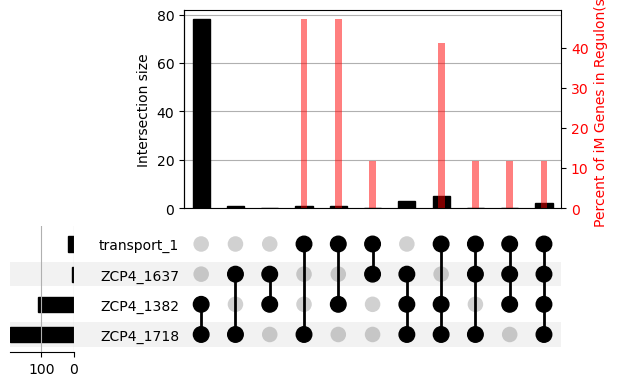

In [11]:
# selection
iM = 'transport_1'
if True:
    # Example data - multiple sets
    sets = {}
    reg_to_size = {}
    for reg in temp[temp['imodulon'] == iM].regulator:
        targets = set(df_trn[df_trn['regulator'] == reg].gene_id)
        reg_to_size.update({reg : len(targets)})
    for reg in [k for k, _ in sorted(reg_to_size.items(), key = lambda k : -k[1])]:
        targets = set(df_trn[df_trn['regulator'] == reg].gene_id)
        sets.update({reg : targets})
    sets.update({iM : set(ica_data.view_imodulon(iM).index)})
    plotting_data = from_contents(sets)
    plotting_data = plotting_data.sort_values(list(sets.keys())[::-1], ascending = False)

    # Plot UpSet
    if len(sets) < 5:
        min_subset_size = 0
    else:
        min_subset_size = 3
    upset = UpSet(plotting_data, include_empty_subsets=True, min_subset_size=min_subset_size,
                  subset_size='count',
                  min_degree=2, sort_by='degree', sort_categories_by='input')
    upset.plot()

    # Get the current axis and create second y-axis
    current_ax = plt.gca()
    ax2 = current_ax.twinx()

    # here is the category order
    cat_groups = upset.intersections.index

    # For each intersection
    for i, combo in enumerate(cat_groups):
        if i < len(current_ax.patches):
            # Get the sets involved
            involved_sets = [name for name, included in zip(plotting_data.index.names, combo) if included]

            # Calculate intersection
            intersection = sets[involved_sets[0]]
            for set_name in involved_sets[1:]:
                intersection = intersection & sets[set_name]

            # Calculate union
            union = sets[involved_sets[0]]
            for set_name in involved_sets[1:]:
                union = union | sets[set_name]

            # Calculate overlap percentage
            iM = None
            for opt in involved_sets:
                if opt in temp.imodulon.values:
                    iM = opt
            if iM:
                overlap_percent = (len(intersection) / len(sets[iM])) * 100
            else:
                overlap_percent = 0

            # Debug print
            #print(f"Bar {i}: {involved_sets} = {len(intersection)} ... {overlap_percent:.2f}%")

            # Plot percentage bar
            x_pos = current_ax.patches[i].get_x() + current_ax.patches[i].get_width()/2
            ax2.bar(x_pos, overlap_percent, width=0.2, color='red', alpha=0.5)

    # Configure second y-axis (optional)
    ax2.set_ylabel('Percent of iM Genes in Regulon(s)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.savefig('../figures/overlaping_sets.pdf', transparent = True)
    plt.show()

In [12]:
involved_sets[1] in temp.imodulon.values

False

In [13]:
involved_sets

['ZCP4_1718', 'ZCP4_1382', 'ZCP4_1637', 'transport_1']

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [14]:
# First search for regulator enrichments with 2 regulators
ica_data.compute_trn_enrichment(max_regs=2,save=True)

# Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
ica_data.compute_trn_enrichment(max_regs=1,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs


The list of regulatory iModulons are shown below

In [15]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
print(len(ica_data.imodulon_table),'Total iModulons')
print(len(regulatory_imodulons),'Regulatory iModulons')
regulatory_imodulons

54 Total iModulons
2 Regulatory iModulons


,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,flipped?,old_name,explained_variance,single_gene,should_be_flipped?,additional_info,category
SG_14,ZCP4_0095+ZCP4_0128,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,NaN,SG_14,0.006527,True,NaN,NaN,single_gene
cell_cycle,ZCP4_0900/ZCP4_0375,9.686758e-10,0.000001,0.605263,0.074675,0.132948,23.0,308.0,38.0,2.0,NaN,noise_3,0.005830,NaN,NaN,NaN,regulatory


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [16]:
#ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
#ica_data.imodulon_table.head()

In [17]:
#regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [18]:
DF_GO = pd.read_csv(path.join(external_data,'GO_annotations_curated.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_name,gene_ontology
45,ZCP4_0936,efp,cytoplasm
46,ZCP4_0936,efp,translation elongation factor activity
65,ZCP4_1645,hisH,imidazoleglycerol-phosphate synthase activity
73,ZCP4_1199,rpe,metal ion binding
74,ZCP4_1199,rpe,"pentose-phosphate shunt, non-oxidative branch"


In [19]:
#DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [20]:
#DF_GO_enrich.head()

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [21]:
DF_KEGG = pd.read_csv(path.join(external_data,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
0,ZCP4_0005,KEGG_pathway,-
8,ZCP4_0006,KEGG_pathway,map00361
9,ZCP4_0006,KEGG_pathway,map00364
10,ZCP4_0006,KEGG_pathway,map00623
11,ZCP4_0006,KEGG_pathway,map01100


In [22]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [23]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
# let's add links to view highlighted KEGG maps
links = []
for index, row in DF_pathway_enrich.iterrows():
    EC_nums = ica_data.view_imodulon(row['imodulon']).EC_number
    EC_num_opts = set()
    for val in EC_nums.values:
        if val == '': continue
        if str(val) == 'nan': continue
        for val2 in val.split(','):
            EC_num_opts.add(val2)
    url = 'https://www.kegg.jp/kegg-bin/show_pathway?map='+row['kegg_id']+'&multi_query='+'%0A'.join(EC_num_opts)
    links.append(url)
DF_pathway_enrich['KEGG_highlight_link'] = links
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [24]:
pd.set_option('display.max_colwidth', None)
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link
0,nitrogen_fixation,map00625,2.310556e-06,4.251423e-04,0.300000,0.500000,0.375000,3.0,6.0,10.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00625&multi_query=1.3.7.7%0A1.18.6.1%0A2.8.1.7
1,nitrogen_fixation,map00910,9.621108e-06,8.851419e-04,0.300000,0.333333,0.315789,3.0,9.0,10.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00910&multi_query=1.3.7.7%0A1.18.6.1%0A2.8.1.7
2,translation_2,map03010,8.003688e-30,1.472679e-27,1.000000,0.339623,0.507042,18.0,53.0,18.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map03010&multi_query=
3,glycolysis_and_ATP_synthase,map00195,4.877813e-18,8.975176e-16,0.346154,1.000000,0.514286,9.0,9.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00195&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14
4,glycolysis_and_ATP_synthase,map00190,4.141932e-13,3.810578e-11,0.346154,0.473684,0.400000,9.0,19.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00190&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14


In [25]:
DF_pathway_enrich[DF_pathway_enrich['kegg_id'] == 'map00030']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link
10,glycolysis_and_ATP_synthase,map00030,0.000051,0.001181,0.153846,0.25,0.190476,4.0,16.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00030&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14


In [26]:
DF_pathway_enrich[DF_pathway_enrich['imodulon'] == 'ETC_and_MEP']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link
35,ETC_and_MEP,map00900,0.000303,0.055691,0.125,0.272727,0.171429,3.0,11.0,24.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00900&multi_query=1.17.7.4%0A2.2.1.7%0A1.6.5.8%0A4.2.1.9%0A1.1.1.219


In [27]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,nitrogen_fixation,M00175,1.165264e-07,2.015907e-05,0.300000,1.000000,0.461538,3.0,3.0,10.0
1,translation_2,M00178,8.003688e-30,1.384638e-27,1.000000,0.339623,0.507042,18.0,53.0,18.0
2,translation_2,M00179,6.066675e-29,5.247673e-27,0.888889,0.516129,0.653061,16.0,31.0,18.0
3,glycolysis_and_ATP_synthase,M00157,4.877813e-18,8.438617e-16,0.346154,1.000000,0.514286,9.0,9.0,26.0
4,glycolysis_and_ATP_synthase,M00001,8.824140e-10,7.632881e-08,0.230769,0.600000,0.333333,6.0,10.0,26.0


### Convert KEGG IDs to human-readable names

In [28]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    if '-' not in key:
        text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    if '-' not in key:
        text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [29]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link,pathway_name
0,nitrogen_fixation,map00625,2.310556e-06,4.251423e-04,0.300000,0.500000,0.375000,3.0,6.0,10.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00625&multi_query=1.3.7.7%0A1.18.6.1%0A2.8.1.7,Chloroalkane and chloroalkene degradation
1,nitrogen_fixation,map00910,9.621108e-06,8.851419e-04,0.300000,0.333333,0.315789,3.0,9.0,10.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00910&multi_query=1.3.7.7%0A1.18.6.1%0A2.8.1.7,Nitrogen metabolism
2,translation_2,map03010,8.003688e-30,1.472679e-27,1.000000,0.339623,0.507042,18.0,53.0,18.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map03010&multi_query=,Ribosome
3,glycolysis_and_ATP_synthase,map00195,4.877813e-18,8.975176e-16,0.346154,1.000000,0.514286,9.0,9.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00195&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14,Photosynthesis
4,glycolysis_and_ATP_synthase,map00190,4.141932e-13,3.810578e-11,0.346154,0.473684,0.400000,9.0,19.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00190&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14,Oxidative phosphorylation


In [30]:
pd.set_option('display.max_colwidth', 1000)
DF_pathway_enrich[DF_pathway_enrich['kegg_id'] == 'map00010']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link,pathway_name
7,glycolysis_and_ATP_synthase,map00010,4.878114e-09,1.795146e-07,0.269231,0.333333,0.297872,7.0,21.0,26.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00010&multi_query=1.1.1.363%0A4.1.1.12%0A5.4.2.11%0A1.1.99.28%0A1.2.1.12%0A2.7.1.2%0A1.1.1.49%0A2.7.2.3%0A4.2.1.12%0A3.1.1.31%0A4.1.1.1%0A2.7.1.40%0A4.1.3.42%0A3.6.3.14%0A4.2.1.11%0A4.1.2.14,Glycolysis / Gluconeogenesis


In [31]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,nitrogen_fixation,M00175,1.165264e-07,2.015907e-05,0.300000,1.000000,0.461538,3.0,3.0,10.0,"Nitrogen fixation, nitrogen => ammonia"
1,translation_2,M00178,8.003688e-30,1.384638e-27,1.000000,0.339623,0.507042,18.0,53.0,18.0,None
2,translation_2,M00179,6.066675e-29,5.247673e-27,0.888889,0.516129,0.653061,16.0,31.0,18.0,None
3,glycolysis_and_ATP_synthase,M00157,4.877813e-18,8.438617e-16,0.346154,1.000000,0.514286,9.0,9.0,26.0,"F-type ATPase, prokaryotes and chloroplasts"
4,glycolysis_and_ATP_synthase,M00001,8.824140e-10,7.632881e-08,0.230769,0.600000,0.333333,6.0,10.0,26.0,"Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate"


## Save files

In [32]:
#DF_GO_enrich['source'] = 'GO'
# DF_pathway_enrich['source'] = 'KEGG pathways'
# DF_module_enrich['source'] = 'KEGG modules'
# DF_subti_enrich['source'] = 'SubtiWiki'

#DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
# DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_subti_enrich.rename({'value':'annotation'},axis=1, inplace=True)

#DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich, DF_subti_enrich])
#DF_enrichments.to_csv(path.join(data_dir,'functional_enrichments.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [33]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

16

In [34]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [35]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,flipped?,old_name,explained_variance,single_gene,should_be_flipped?,additional_info,category
SG_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_1,0.001280,True,NaN,NaN,single_gene
SG_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_2,0.003298,True,NaN,NaN,single_gene
SG_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_3,0.002938,True,NaN,NaN,single_gene
SG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_4,0.000968,True,NaN,NaN,single_gene
SG_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_5,0.006583,True,NaN,NaN,single_gene
SG_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_6,0.006868,True,NaN,NaN,single_gene
SG_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_7,0.000839,True,NaN,NaN,single_gene
SG_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_8,0.004646,True,NaN,NaN,single_gene
SG_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_9,0.000502,True,NaN,NaN,single_gene
SG_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,SG_10,0.001512,True,NaN,NaN,single_gene


In [36]:
ica_data.view_imodulon('SG_1')

,gene_weight,gene_name,accession,start,end,strand,gene_product,COG,regulator,uniprot,...,aero_glucose_model_growth_perc_change,FIMO_regulators,LDI_early_glucose_fold_change,LDI_late_glucose_fold_change,LDI_early_xylose_fold_change,LDI_late_xylose_fold_change,no_LDI_early_glucose_fold_change,no_LDI_late_glucose_fold_change,no_LDI_early_xylose_fold_change,no_LDI_late_xylose_fold_change
ZCP4_1051,0.563768,ZCP4_1051,CP006818.1,1183893.0,1184051.0,-,hypothetical protein,No COG annotation,NaN,NaN,...,1.0,"['CosR_Campylobacter_jejuni', 'NikR_Helicobacter_pylori']",1.0,0.602856,0.267945,0.603849,1.0,0.642978,0.794318,1.087439


# add on chromosome/plasmid location

In [37]:
f = open('../Zymomonas_mobilis/sequence_files/genome.gff3', 'r')
lines = f.readlines()
f.close()
gene_to_reg = {}
for line in lines:
    if '##sequence-region' in line:
        seq_region = line.split(' ')[1]
    if 'ID=gene-' in line:
        gene = line.split('ID=gene-')[1].split(';')[0]
        gene_to_reg.update({gene : seq_region})
        
new_col = [gene_to_reg[index] for index in ica_data.gene_table.index]
ica_data.gene_table['chromosome_id'] = new_col

# what iModulons are "most essential"?

In [38]:
aero = []
anaero = []
for iM in ica_data.imodulon_table.index:
    df = ica_data.view_imodulon(iM)
    total = len(df)
    if 0 not in df['aerobic_essential'].value_counts():
        aerobic_ess = 1
    else:
        aerobic_ess = (total - df['aerobic_essential'].value_counts()[0]) / total
    if 0 not in df['anaerobic_essential'].value_counts():
        anaerobic_ess = 1
    else:
        anaerobic_ess = (total - df['anaerobic_essential'].value_counts()[0]) / total
    aero.append(aerobic_ess)
    anaero.append(anaerobic_ess)
ica_data.imodulon_table['percent_anaero_essential'] = anaero
ica_data.imodulon_table['percent_aero_essential'] = aero

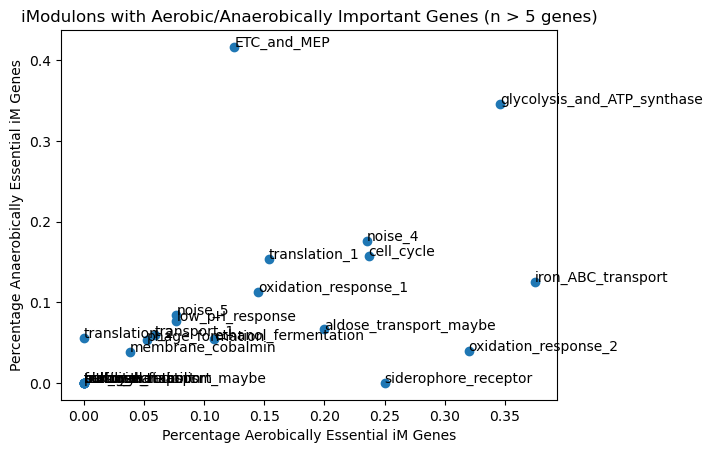

In [39]:
df = ica_data.imodulon_table
df = df[df['imodulon_size'] > 5]
df.sort_values(by = 'percent_anaero_essential', ascending = False)[['category', 'explained_variance', 'imodulon_size', 'percent_aero_essential', 'percent_anaero_essential']]
x = df['percent_aero_essential']
y = df['percent_anaero_essential']
plt.scatter(x, y)
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]))
plt.xlabel('Percentage Aerobically Essential iM Genes')
plt.ylabel('Percentage Anaerobically Essential iM Genes')
plt.title('iModulons with Aerobic/Anaerobically Important Genes (n > 5 genes)')
plt.savefig('../figures/aerobic_essential_anaerobic_essential_iM_scatter.pdf', transparent = True)
plt.show()

# add iModulons to gene_info

In [40]:
iMs = []
gene_to_iMs = {}
for iM in ica_data.imodulon_table.index:
    df = ica_data.view_imodulon(iM)
    for gene in df.index:
        if gene not in gene_to_iMs:
            gene_to_iMs.update({gene : []})
        gene_to_iMs[gene].append(iM)
for gene in ica_data.gene_table.index:
    if gene not in gene_to_iMs:
        iMs.append('')
    else:
        val = gene_to_iMs[gene]
        val.sort()
        iMs.append(str(val))
ica_data.gene_table['iMs'] = iMs

# Save iModulon object

In [41]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [42]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [43]:
save_to_json(ica_data, path.join('..','data','interim','zmo_raw.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [44]:
ica_data.imodulon_table.to_csv(path.join('..','data','processed_data','imodulon_table_raw.csv'))

# what are iModulons not capturing?

In [45]:
M = ica_data.M
A = ica_data.A
rec_X = M.dot(A).T
gene_to_corr = {}
for gene in rec_X.columns:
    gene_to_corr.update({gene : np.corrcoef(rec_X[gene], ica_data.X.T[gene])[0,1]})
worst_genes = [k for k, _ in sorted(gene_to_corr.items(), key = lambda k : k[1])]
gene_info = ica_data.gene_table.copy()
corr_vals = []
for index in gene_info.index:
    corr_vals.append(gene_to_corr[index])
gene_info['corr_rec'] = corr_vals
gene_info['mean_exp'] = abs(ica_data.X.loc[gene_info.index]).mean(axis = 1)
bad_genes = gene_info[gene_info['corr_rec'] < 0.5]
good_genes = gene_info[gene_info['corr_rec'] >= 0.5]

In [46]:
a = bad_genes.sort_values(by = 'corr_rec').value_counts('COG', normalize = True)
a

COG
Function unknown                                                     0.173752
No COG annotation                                                    0.155268
Amino acid transport and metabolism                                  0.097967
Cell wall/membrane/envelope biogenesis                               0.073937
Transcription                                                        0.059150
Coenzyme transport and metabolism                                    0.051756
Translation, ribosomal structure and biogenesis                      0.051756
Post-translational modification, protein turnover, and chaperones    0.044362
Replication, recombination and repair                                0.044362
Energy production and conversion                                     0.042514
Inorganic ion transport and metabolism                               0.027726
Carbohydrate transport and metabolism                                0.025878
Cell cycle control, cell division, chromosome partitioning  

In [47]:
b = good_genes.value_counts('COG', normalize = True)
b

COG
Function unknown                                                     0.172973
Translation, ribosomal structure and biogenesis                      0.096525
No COG annotation                                                    0.087259
Amino acid transport and metabolism                                  0.083398
Cell wall/membrane/envelope biogenesis                               0.064093
Energy production and conversion                                     0.060232
Replication, recombination and repair                                0.049421
Transcription                                                        0.049421
Inorganic ion transport and metabolism                               0.045560
Nucleotide transport and metabolism                                  0.041699
Coenzyme transport and metabolism                                    0.039382
Carbohydrate transport and metabolism                                0.036293
Post-translational modification, protein turnover, and chape

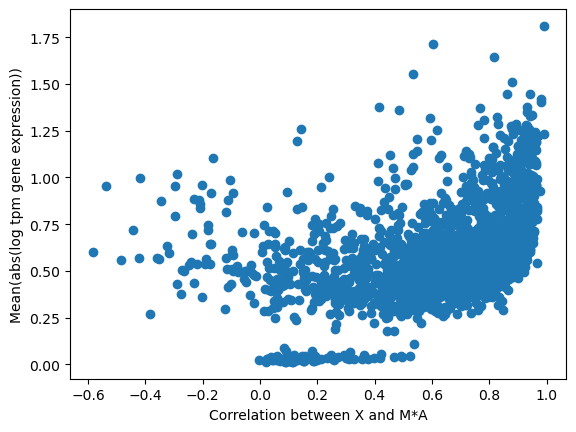

In [75]:
plt.scatter(gene_info['corr_rec'], gene_info['mean_exp'])
plt.xlabel('Correlation between X and M*A')
plt.ylabel('Mean(abs(log tpm gene expression))')
plt.savefig('../figures/recreated_expression.pdf', transparent = True)
plt.show()

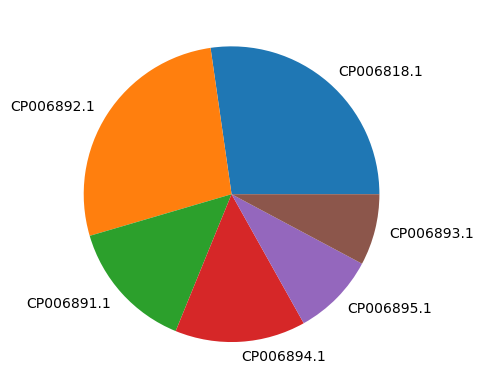

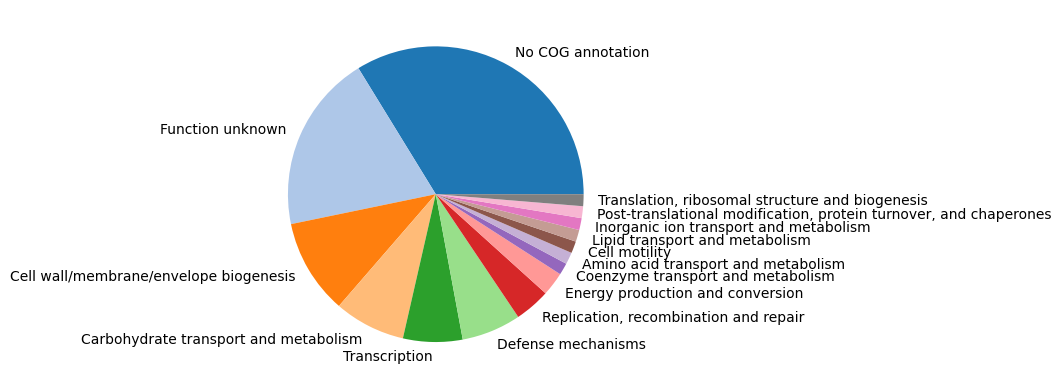

In [86]:
# pie charts of genes not captured
info = gene_info[gene_info['mean_exp'] < 0.1].value_counts('chromosome_id')
order = info.index
plt.pie(x = info.values, labels = info.index)
plt.savefig('../figures/low_expr_chromes.pdf', transparent = True)
plt.show()

info = gene_info[gene_info['mean_exp'] < 0.1].value_counts('COG')
order2 = info.index
plt.pie(x = info.values, labels = info.index, colors=plt.cm.tab20.colors)
plt.savefig('../figures/low_expr_COGS.pdf', transparent = True)
plt.show()

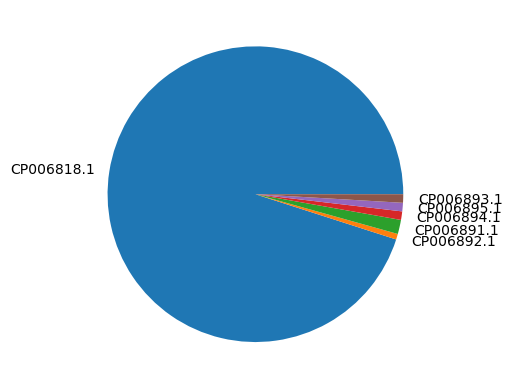

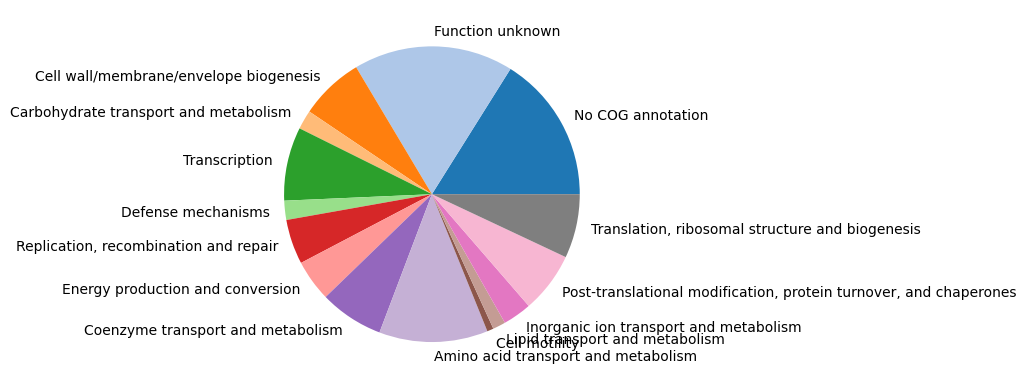

In [101]:
# pie charts of genes not recreated
info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] < 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('chromosome_id').loc[order]
plt.pie(x = info.values, labels = info.index)
plt.savefig('../figures/bad_corr_chromes.pdf', transparent = True)
plt.show()

info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] < 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('COG').loc[order2]
plt.pie(x = info.values, labels = info.index, colors=plt.cm.tab20.colors)
plt.savefig('../figures/bad_corr_COGS.pdf', transparent = True)
plt.show()

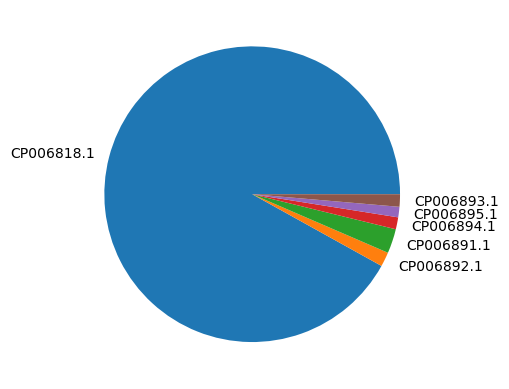

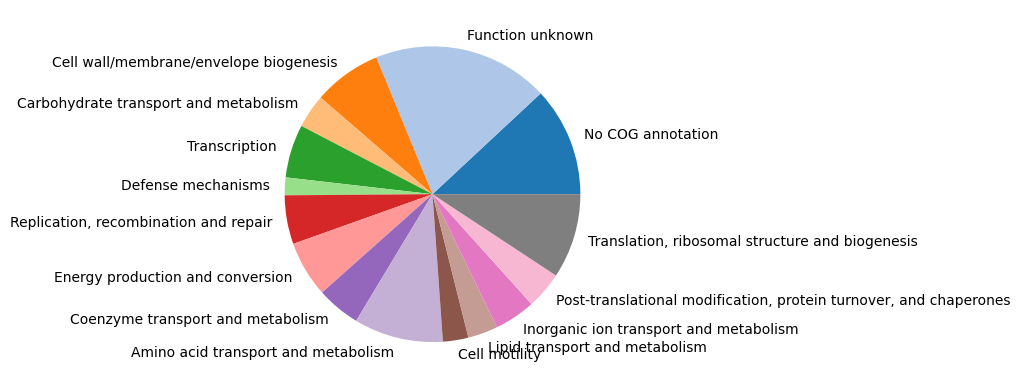

In [88]:
# pie chart of all genes
info = gene_info.value_counts('chromosome_id').loc[order]
plt.pie(x = info.values, labels = info.index)
plt.savefig('../figures/all_chromes.pdf', transparent = True)
plt.show()

info = gene_info.value_counts('COG').loc[order2]
plt.pie(x = info.values, labels = info.index, colors=plt.cm.tab20.colors)
plt.savefig('../figures/all_COGS.pdf', transparent = True)
plt.show()

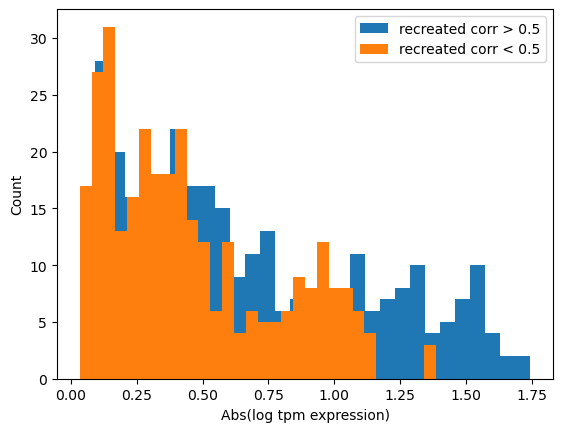

In [51]:
plt.figure()
plt.hist(abs(ica_data.X.loc[good_genes.index]).mean(), bins = 30, label = 'recreated corr > 0.5')
plt.hist(abs(ica_data.X.loc[bad_genes.index]).mean(), bins = 30, label = 'recreated corr < 0.5')
plt.xlabel('Abs(log tpm expression)')
plt.ylabel('Count')
plt.legend()
plt.show()

# playground